Epoch: 1000 cost = 2.402709
Epoch: 2000 cost = 2.402159
Epoch: 3000 cost = 2.223073
Epoch: 4000 cost = 2.203468
Epoch: 5000 cost = 2.443486


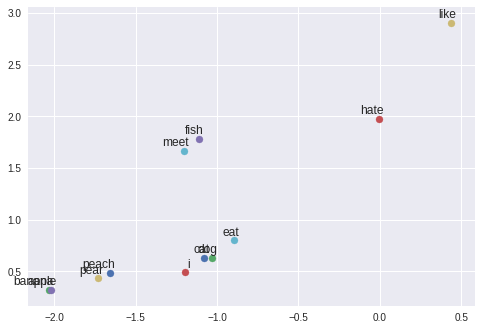

In [0]:
'''
  code by Minho Ryu @bzantium
  reference : https://github.com/theeluwin/pytorch-sgns
              https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py
              
'''
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import LongTensor as LT
from torch import FloatTensor as FT

# Words Sentence
sentences = [  "i eat meet",   "i eat fish",   "i like apple",   "i hate pear",   "i like banana",   "i hate peach",
             "dog eat meet", "dog eat fish", "dog like apple", "dog hate pear", "dog like banana", "dog hate peach",
             "cat eat meet", "cat eat fish", "cat like apple", "cat hate pear", "cat like banana", "cat hate peach"]


word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20
embedding_size = 2 # To show 2 dim embedding graph
num_sampled = 10 # for negative sampling, less than batch_size
vocab_size = len(word_list)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

# Model
class Word2Vec(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.ivectors = nn.Embedding(self.vocab_size, self.embedding_size)
        self.ovectors = nn.Embedding(self.vocab_size, self.embedding_size)
        self.ivectors.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embedding_size), 
                                                       FT(self.vocab_size - 1, self.embedding_size).
                                                       uniform_(-0.5 / self.embedding_size, 0.5 / self.embedding_size)]))
        self.ovectors.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embedding_size), 
                                                       FT(self.vocab_size - 1, self.embedding_size).
                                                       uniform_(-0.5 / self.embedding_size, 0.5 / self.embedding_size)]))
        self.ivectors.weight.requires_grad = True
        self.ovectors.weight.requires_grad = True

    def forward(self, data):
        return self.forward_i(data)

    def forward_i(self, data):
        v = data.cuda() if self.ivectors.weight.is_cuda else data
        return self.ivectors(v)

    def forward_o(self, data):
        v = data.cuda() if self.ovectors.weight.is_cuda else data
        return self.ovectors(v)


class SGNS(nn.Module):

    def __init__(self, model, vocab_size, n_negs, weights=None):
        super(SGNS, self).__init__()
        self.model = model
        self.vocab_size = vocab_size
        self.n_negs = n_negs
        self.weights = None
        if weights is not None:
            wf = np.power(weights, 0.75)
            wf = wf / wf.sum()
            self.weights = FT(wf)

    def forward(self, iword, owords):
        batch_size = iword.size(0)
        context_size = owords.size(1)
        if self.weights is not None:
            nwords = torch.multinomial(self.weights, batch_size * context_size * self.n_negs, replacement=True).view(batch_size, -1)
        else:
            nwords = FT(batch_size, context_size * self.n_negs).uniform_(0, self.vocab_size - 1).long()
        ivectors = self.model.forward_i(iword).unsqueeze(2)
        ovectors = self.model.forward_o(owords)
        nvectors = self.model.forward_o(nwords).neg()
        oloss = torch.matmul(ovectors, ivectors).squeeze().sigmoid().log().mean()
        nloss = torch.matmul(nvectors, ivectors).squeeze().sigmoid().log().view(-1, context_size, self.n_negs).sum(2).mean()
        return -(oloss + nloss).mean()
      

model = Word2Vec(vocab_size=vocab_size, embedding_size=2)
sgns = SGNS(model=model, vocab_size=vocab_size, n_negs=5)
optim = torch.optim.Adam(sgns.parameters(), lr=0.001)


# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    input_batch = LT(input_batch)
    target_batch = LT(target_batch)

    optim.zero_grad()
    loss = sgns(input_batch, target_batch)
    loss.backward()
    optim.step()

    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    
for i, label in enumerate(word_list):
    W, _ = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()